In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random as rn
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from PIL import Image

import json

%matplotlib inline

In [ ]:
X_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_train_data_with_aug_64.npy')
X_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_val_data_with_aug_64.npy')
X_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_test_data_with_aug_64.npy')
Y_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_train_data_with_aug_64.npy')
Y_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_val_data_with_aug_64.npy')
Y_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_test_data_with_aug_64.npy')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(X_train, Y_train, batch_size=16, shuffle=True) # 훈련은 랜덤으로 추출
flow_val_gen = valid_generator.flow(X_val, Y_val, batch_size=16, shuffle=False) # 검증 또는 테스트는 순차적으로 추출


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model.add(densenet)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.optimizers import Adam , RMSprop

checkpoint_path = 'densenet_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(flow_tr_gen, epochs=50, batch_size=32, validation_data=flow_val_gen, callbacks=[rlr, ely, checkpoint])

Epoch 1/50
227/227 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.5036
Epoch 1: val_accuracy improved from -inf to 0.51104, saving model to densenet_model.h5
227/227 [==============================] - 102s 114ms/step - loss: 1.0970 - accuracy: 0.5036 - val_loss: 1.0451 - val_accuracy: 0.5110 - lr: 1.0000e-04
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.6502
Epoch 2: val_accuracy improved from 0.51104 to 0.60706, saving model to densenet_model.h5
227/227 [==============================] - 22s 99ms/step - loss: 0.7499 - accuracy: 0.6502 - val_loss: 0.8592 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7413
Epoch 3: val_accuracy improved from 0.60706 to 0.63907, saving model to densenet_model.h5
227/227 [==============================] - 26s 113ms/step - loss: 0.5942 - accuracy: 0.7413 - val_loss: 0.8515 - val_accuracy: 0.6391 - lr: 1.0

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(X_test, Y_test, batch_size=16, shuffle=False)
model.evaluate(flow_test_gen) # loss, accuarcy

18/18 [==============================] - 1s 73ms/step - loss: 1.3569 - accuracy: 0.7077


[1.3569332361221313, 0.7077465057373047]

18/18 [==============================] - 1s 41ms/step - loss: 1.3569 - accuracy: 0.7077
Test Accuracy: 70.77%
18/18 [==============================] - 1s 34ms/step
Confusion Matrix:
[[103  12   6]
 [ 28  66  11]
 [  5  21  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       121
           1       0.67      0.63      0.65       105
           2       0.65      0.55      0.60        58

    accuracy                           0.71       284
   macro avg       0.69      0.68      0.68       284
weighted avg       0.70      0.71      0.70       284



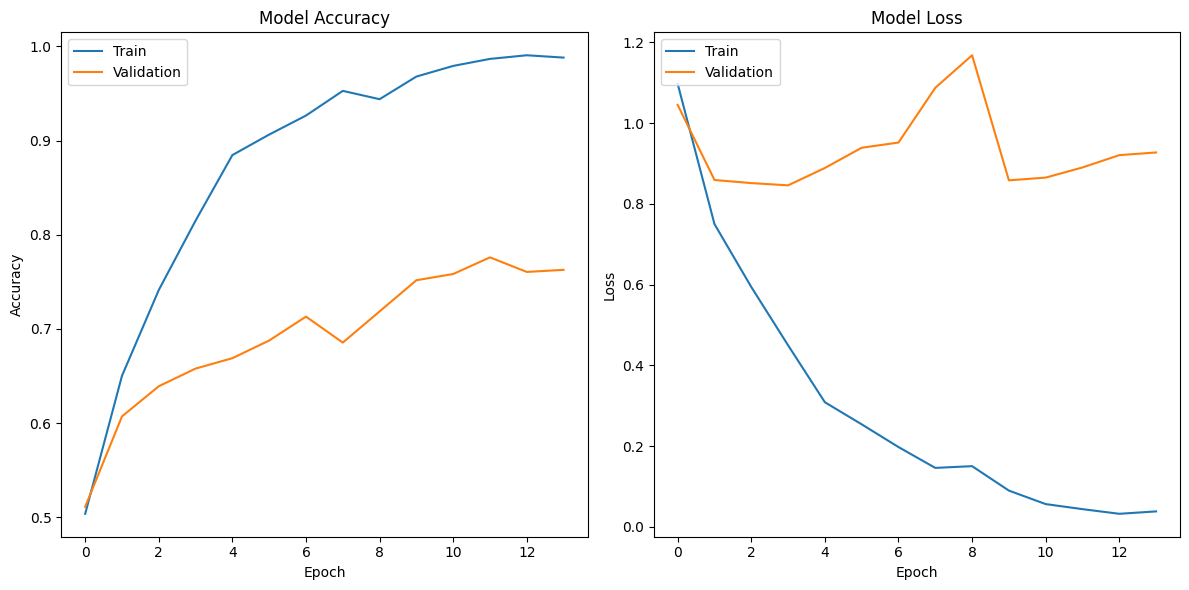

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


test_loss, test_acc = model.evaluate(flow_test_gen)
print(f'Test Accuracy: {test_acc*100:.2f}%')

predictions = model.predict(flow_test_gen)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = []
batch_index = 0
while batch_index <= flow_test_gen.batch_index:
    data = flow_test_gen.next()
    true_labels.append(np.argmax(data[1], axis=1))
    batch_index += 1

true_labels = np.concatenate(true_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()